# Homework 5

## The Heat Equation and the Wave Equation 

### This is the solution of:
* Student1
* Student2
* Student3



The same general rules as for Homework 1 applies.

$\newcommand{\dx}{\,\mathrm{d}x}$ 
$\newcommand{\dy}{\,\mathrm{d}y}$
$\newcommand{\dS}{\,\mathrm{d}S}$

In [1]:
# Make plotted figures interactive
%matplotlib inline

In [2]:
# Download the updated plottools.py file from lab_05 and import it!
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import factorized 
import plottools as pt
import meshtools as mt
import numpy as np
from scipy.sparse import identity
import matplotlib.pyplot as plt
from matplotlib import cm

## Problem 1 (The heat equation)

In the following, you are asked to implement the $\theta$ scheme 
combined with the finite element method
as space discretization to solve the heat equation

\begin{alignat*}{3}
\partial_t u  - \Delta u  &= f  \quad && \text{in } \Omega \times (0,T]
\\
u &= g_D \quad && \text{on } \partial \Omega \times (0, T]
\\
u(x,y,0) &=  u_0(x,y) \quad && \text{in } \Omega
\end{alignat*}

with initial value $u_0$, bounday value $g_D$ and final time $T$.

Given a constant step size $\Delta t$ in time, recall that the $\theta$-scheme resulted in a full discretization of the heat equation of the general form
\begin{align*}
(M +  \Delta t\theta A) U^k = (M -  \Delta t \overline{\theta} h A) U^{k-1}
+ \widetilde{F}^k 
\end{align*}
plus boundary conditions. We define $\overline{\theta} = 1 - \theta$.

**a**) Implement a full discretization for the 2d heat equation with $\Omega = (0, 2\pi)^2$ by combining the $\theta$ scheme with the finite element method in space. The data $f$, $g_D$, $u_0$, $T$ are defined later in c) and d). 



To encourage code reuse, wrap your assembler functions from Lab 04
* assemble_mass_matrix
* assemble_stiffness_matrix
* assemble_load_vector 

into a separate assembler module named $\texttt{assemble.py}$ (Don't forget to include helper like $\texttt{compute_hat_grad}$). In principle, the module should like this:

In [3]:
# assemble.py module
import numpy as np
import scipy.sparse as sp

def compute_hat_gradients(tri):
    # Compute area
    N0, N1, N2 = tri
    area=abs(0.5*np.cross(N1-N0, N2-N0))
    
    # Compute b = (1,1,1) x (x_2^1,x_2^2,x_2^3). c is similar
    ones = np.ones(3)
    b = np.cross(tri[:,1], ones)/(2*area)
    c = np.cross(ones, tri[:,0])/(2*area)

    return (area, b, c)

def assemble_stiffness_matrix(P, T):
    # Create matrix as before
    # As in the mass matrix assembly:
    # Deduce number of unkowns from dimensions of P
    # number of elements from dimensions of T and sparse matrix A
    n_p = P.shape[0]
    n_t = T.shape[0]
    A = np.zeros((n_p, n_p))

    for  K in range(n_t):
        # Get local to global map
        loc2glo = T[K,:]
        # Get triangle coordinates and compute area
        tri = P[T[K,:]]
        N0 = tri[0]
        N1 = tri[1]
        N2 = tri[2]
        
        # Compute abar = a((N0 + N1 + N2)/3) to approximate \int_K a(x)dx
        abar = a((N0 + N1 + N2)/3)
        
        # Compute the area and the coefficient for the hat gradients
        area, b, c = compute_hat_gradients(tri)

        # Numpy Arrays does not behave exactly like n x 1 matrices
        # To compute the outer product b*b.T or  b*b' in Matlab notation
        # we need the np.outer function
        A_K = abar*(np.outer(b, b) + np.outer(c, c))*area
        
        # Add local element matrix to global matrix as before
        A[np.ix_(loc2glo, loc2glo)] += A_K

    return A

def assemble_mass_matrix(P, T):
    # Define constant part M_K here
    M_ref = 1/12*np.array([[2, 1, 1], 
                           [1, 2, 1], 
                           [1, 1, 2]])
    
    # Deduce number of unkowns from dimensions/shape of P
    n_p = P.shape[0]
    # Deduce number of elements from dimensions of T
    n_t = T.shape[0]
    
    # Create sparse matrix M
    M = sp.dok_matrix((n_p, n_p))
    
    for  K in range(n_t):
        # Get local to global map from T
        l2g = T[K]
        # Get triangle nodes from P
        tri = P[T[K]]
        # Unpack nodes into N1,N2,N3
        N0,N1,N2 = tri 
        # Compute area of K. 
        # Convince yourself that the following line computes the area |K|
        # area = 0.5 * abs((N1[0] - N0[0])*(N2[1] - N0[1]) -
        #                (N1[1] - N0[1])*(N2[0] - N0[0]))
        area = abs(0.5*np.cross(N1-N0, N2-N0))
        # Use area and M_ref to compute M_K
        M_K = area*M_ref
        # Instead of 2 loops we can slice out the blocks which
        # corresponds to the entries in l2g by using the funny
        # function ix_ in numpy
        M[np.ix_(l2g, l2g)] += M_K
    
    return M

def assemble_load_vector(P, T, f, qr = "midpoint_2d"):
    """ Assembles the load vector """
    
    # Deduce number of unkowns from dimensions/shape of P
    n_p = P.shape[0]
    # Deduce number of elements from dimensions of T
    n_t = T.shape[0]
    
    
    # Create and intialize vector
    b = np.zeros(n_p)
    
    # Iterate over all triangles
    for  K in range(n_t):
        l2g = T[K]   # Get local to global map
        tri = P[T[K]]  # Get triangle coordinates and compute area
        N0,N1,N2 = tri 
        #area = 0.5 * abs((N1[0] - N0[0])*(N2[1] - N0[1]) -
        #                (N1[1] - N0[1])*(N2[0] - N0[0]))
        area = abs(0.5*np.cross(N1-N0, N2-N0))
        if qr == "midpoint_2d":   
            # 2d midpoint
            # three midpoint coordinates
            N01 = (N0 + N1)/2
            N12 = (N1 + N2)/2
            N20 = (N0 + N2)/2
            
            b_K = area/6*np.array([f(N01)+f(N20), f(N01)+f(N12), f(N12)+f(N20)])
            # b_K = area/3*np.array([f(N01), f(N12), f(N20)])            
        else:
            # 2d Trapezoid
            b_K = area/3*np.array([f(N0), f(N1), f(N2)])
        # Add local contributions to the global load vector
        b[l2g] += b_K
        
    return b

def apply_bcs_to_A(A, dirichlet_nodes):
    # Incorporate boundary conditions in matrix A
    # Set all rows corresponding to Dirichlet nodes to 0
    A[dirichlet_nodes, :] = 0 
    
    # Set diagonal to one
    A[dirichlet_nodes, dirichlet_nodes] = 1

def apply_bcs_to_b(b, g_D_values, dirichlet_nodes):
    # Incorporate boundary condition in vector b
    b[dirichlet_nodes] = g_D_values

# And so on


Then you can simply use the functions from your new cool module by importing everything
into this notebook:

In [4]:
from assembly import *

Next, we split our previous $\texttt{apply_bcs}$ functions into two parts:
* one which manipulates the rows related to the Dirichlet nodes in a given matrix
(as described in Lab 04) and which will be needed only once.
* one which incorporates the Dirichlet data into given rhs vector b (needed in every time step)

In [5]:
def apply_bcs_to_A(A, dirichlet_nodes):
    # Incorporate boundary conditions in matrix A
    # Set all rows corresponding to Dirichlet nodes to 0
    A[dirichlet_nodes, :] = 0 
    
    # Set diagonal to one
    A[dirichlet_nodes, dirichlet_nodes] = 1

def apply_bcs_to_b(b, g_D_values, dirichlet_nodes):
    # Incorporate boundary condition in vector b
    b[dirichlet_nodes] = g_D_values

Of course, it would be nice to encapsulate these functions into the $\text{assemble.py}$ module as well, so move them there and make sure that you rerun the cell with the 
```Python
from assemble import *
```
statement to reimport your new functions.

In [6]:
from assembly import *
import meshtools as mt
import plottools as pt

Finally, do the same with our 
```extract_nodes(P, inside_domain)``` from Lab 04.

Now you are well equipped to implement your own solver. Start again by defining functions for the given data.

In [7]:
# Exact solution (to be used for testing purpose and EOC later)
def u_ex(x, y, t):
    lamb = -2
    return np.sin(x)*np.sin(y)*np.exp(-2*t)

# Right hand side
def f(x, y, t):
    return 0*np.ones_like(x)

# Initial condition
def u_0(x, y):
    return np.sin(x)*np.sin(y)

# Boundary condition
def g_D(x, y, t):
    return 0*np.ones_like(x)

# Start/end time
t0, T = 0, 1

Next, we define the dimensions of the domain and the Dirichlet boundary.

In [8]:
def on_dirichlet_boundary(x):
    eps = 1e-12
    L = 2*np.pi
    return  (x[0] < eps or x[0] > L - eps or
             x[1] < eps or x[1] > L - eps)

As usual, you need a mesh. (Don't forget to import the meshtools and plottools.)

In [9]:
# Define number of subdivision in each spatial direction
N = 10

# Mesh size
h = 2*np.pi/N

# Mesh and coordinates
points, triangles = mt.rectangle_mesh((0,0), (2*np.pi,2*np.pi), N, N)
X = points[:, 0]
Y = points[:, 1]

In [10]:
# Define stepsize in time, number of time steps, theta, thetabar.
alpha = 0.1
m = 1 # Trap - 1, BE,FE - 2
dt = alpha*h**m # choose alpha and m appropriately
N_time = int(np.ceil(T / dt)) # number of total time steps
dt = T / N_time
theta = 0.5 # trap
thetabar = 1 - theta # one more thing here -  what could this be?

Now you can assemble the required mass and stiffness matrices and compute
the matrices which are involved in the left and right hand side of a time step computation.
As before,  Dirichlet conditions must be accounted for in the lhs matrix.

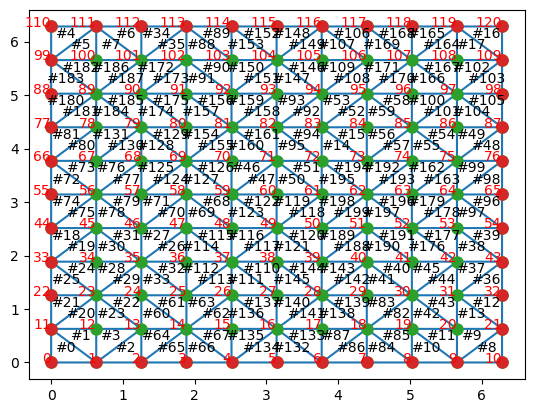

C:\Users\Isac\anaconda3\Lib\site-packages\scipy\sparse\_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [11]:
# Compute mass matrix
M = assemble_mass_matrix(points,triangles)

# Compute stiffness matrix
a = lambda x: 1
A = assemble_stiffness_matrix(points,triangles, a)

# Compute total matrix for lhs 
A_tot = M + dt*theta*A

# Compute total matrix for rhs
B_tot = M - dt*theta*A

# Extract Dirichlet nodes 
dirichlet_nodes  = extract_nodes(points, on_dirichlet_boundary)

# Plot them for visual check whether you extracted the right ones.
if N < 11:
    # Plot mesh including dirichlet nodes
    pt.plot_mesh_2d(points, triangles, dirichlet_nodes)

# Adjust rows associated with Dirchlet bc
A = apply_bcs_to_A(A_tot,dirichlet_nodes) 
B = apply_bcs_to_A(B_tot,dirichlet_nodes)

# Convert final matrix to csc format and precompute LU composition
A_tot = A_tot.tocsc()
solve = factorized(A_tot)

Before you can start with the time step looping, an approximation of $u_0$ is needed.

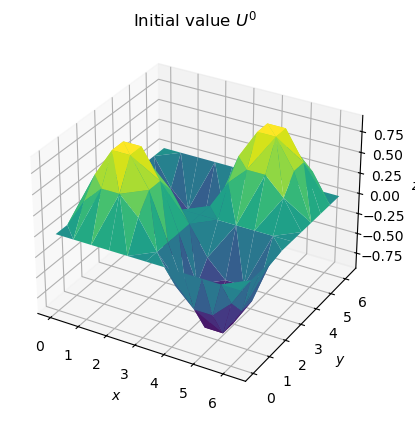

In [12]:
# Current time
t = t0

# (Indirect) interpolation (works only this way since a row wise
# numbering of the nodes is used when the mesh is created!
# Alternative would be to compute the L2 projection
U = u_0(X, Y)
pt.plot2D(X, Y, U, triangles=triangles, title="Initial value $U^0$")
U = U.ravel()

Finally, into the time step looping!

In [13]:
# Start time stepping 
for i in range(N_time):

    # New time and index of time step
    t += dt

    # Compute right hand side action on U
    rhs = B_tot.dot(U)

    # Define \tilde F  
    load = assemble_load_vector_in_time(points, triangles, f, t)
    load_old = assemble_load_vector_in_time(points, triangles, f, t-dt)
    f_tilde = dt*(thetabar*load_old + theta*load)
    # and assemble the load vector using f_tilde and add it to the rhs
    rhs += f_tilde

    # Extract coordinates associated with Dirichlet nodes as before in Lab 04
    X_dc = X[dirichlet_nodes]
    Y_dc = Y[dirichlet_nodes]

    # Evaluate g at boundary nodes and time t
    g_D_values = g_D(X_dc, Y_dc, t)

    # Apply Dirichlet boundary condition to rhs
    apply_bcs_to_b(rhs, g_D_values, dirichlet_nodes)

    #Solve system
    U = solve( rhs )
print(t) # if t differs from T more than machine precision, then there is bug!
print(T) # test

1.0
1


Great, your are done! Time to plot things:

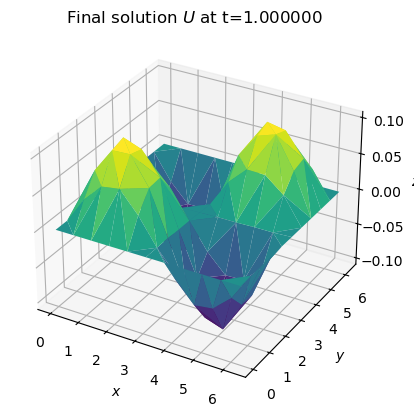

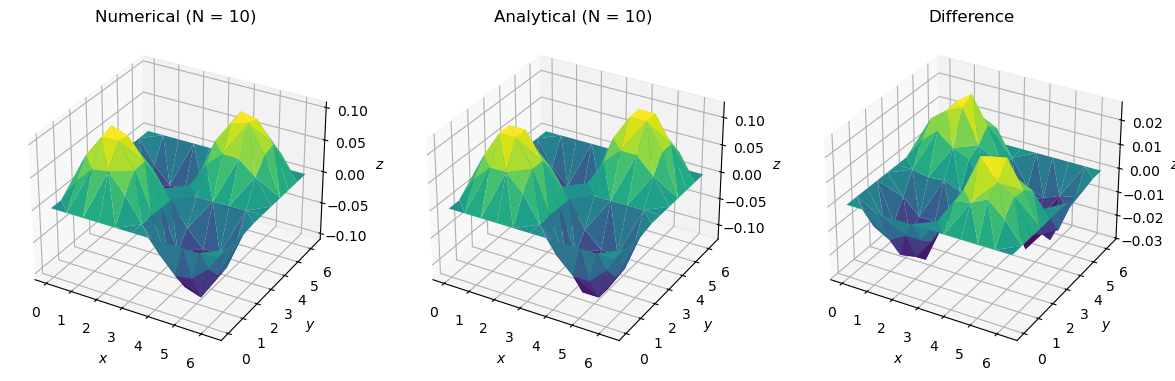

In [14]:
pt.plot2D(X, Y, U, triangles=triangles, title="Final solution $U$ at t=%f" %t)

U_ex = u_ex(X, Y, t)
pt.plot_comparison_2D(X,Y,U,U_ex,triangles,f"Numerical (N = {N})",f"Analytical (N = {N})")

**c**) Now we use the solver to perform a test on EOC. First, take the initial data $u_0=\sin(x)\sin(y)$ and the  ansatz $u_{ex}(x,y,t) = e^{\lambda t}u_0(x,y)$ for the exact solution. Substitute $u_{ex}$ into the heat equation and determine $\lambda$ so that $u_{ex}$ is the exact solution to the heat equation with $f=0$. Also compute the boundary data $g_D$ by using $u_{ex}$. 

Next, make sure that t-T is close to machine precision after the time loop. If not, there is a bug in the code. 
Now plot the exact solution $u$, the computed solution $U$ and their difference
at the final time $T=1$ for spatial mesh sizes $h = 2\pi/N$, $N=10, 20, 40$ and for $\theta \in \{ 0, 1, 0.5\}$. How should you choose the time step in each case?

Do you see a seond order convergence in maximum norm? Is this reasonable for all $\theta$ values you have tested?

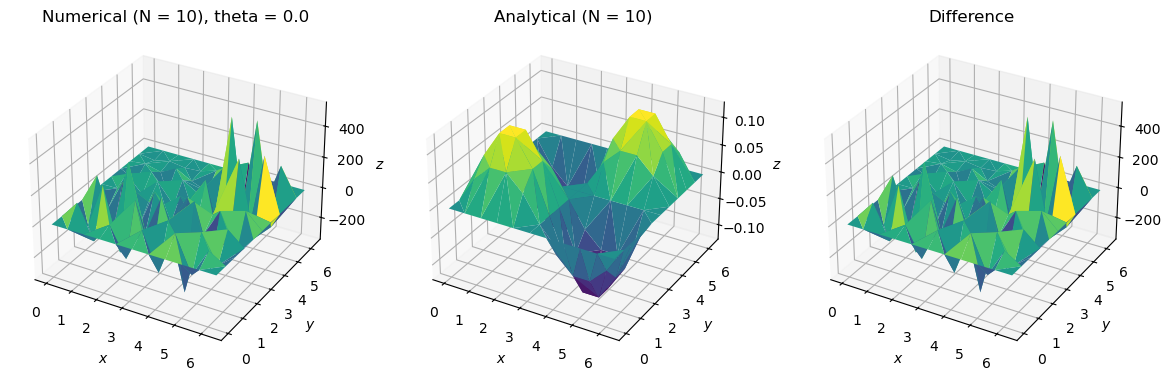

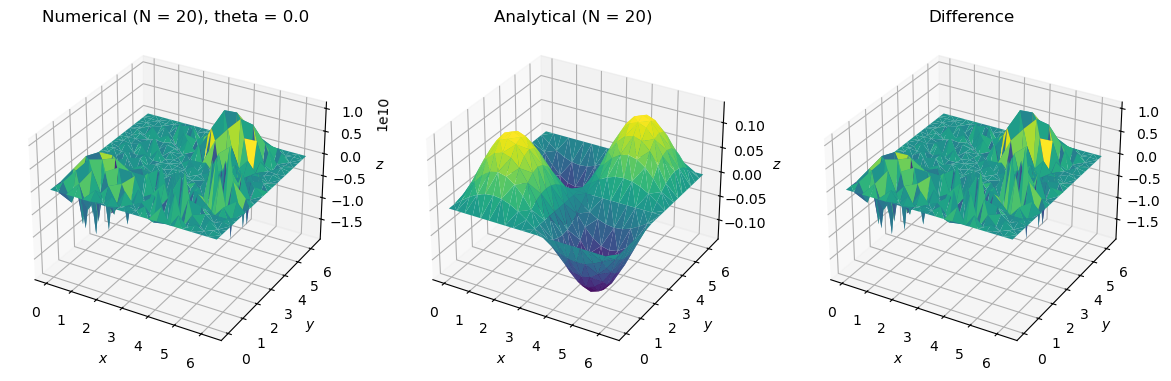

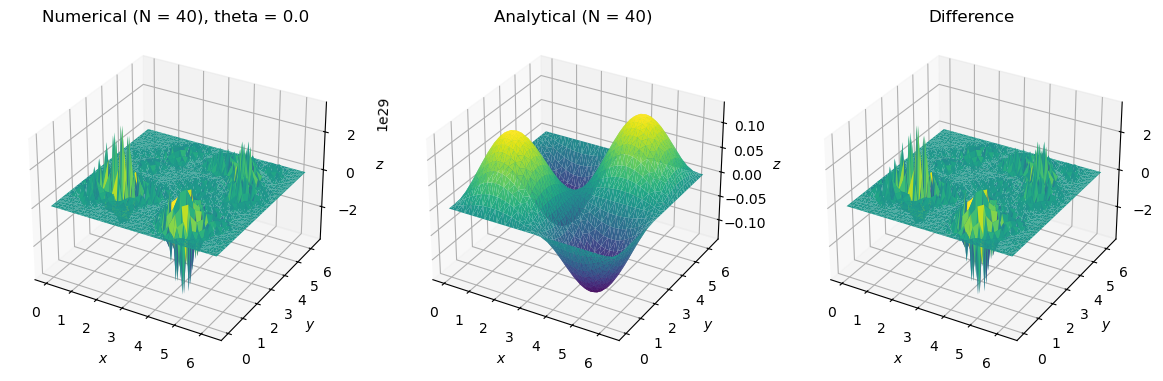

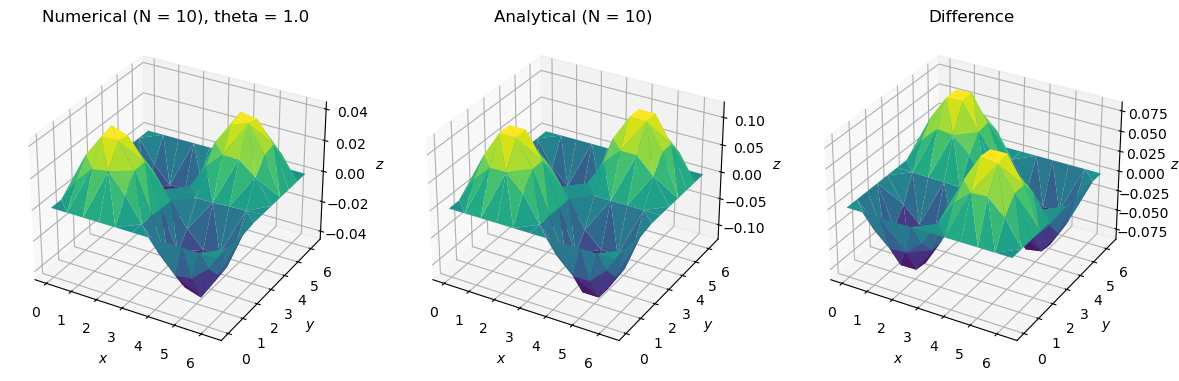

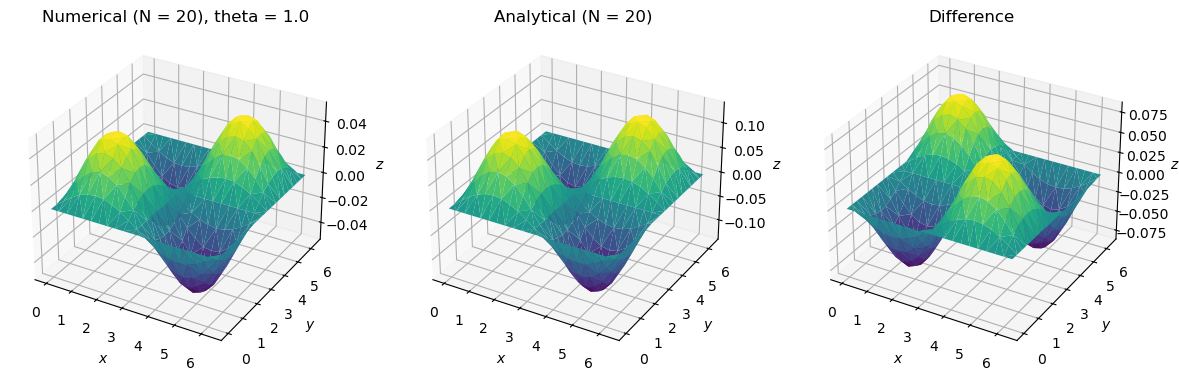

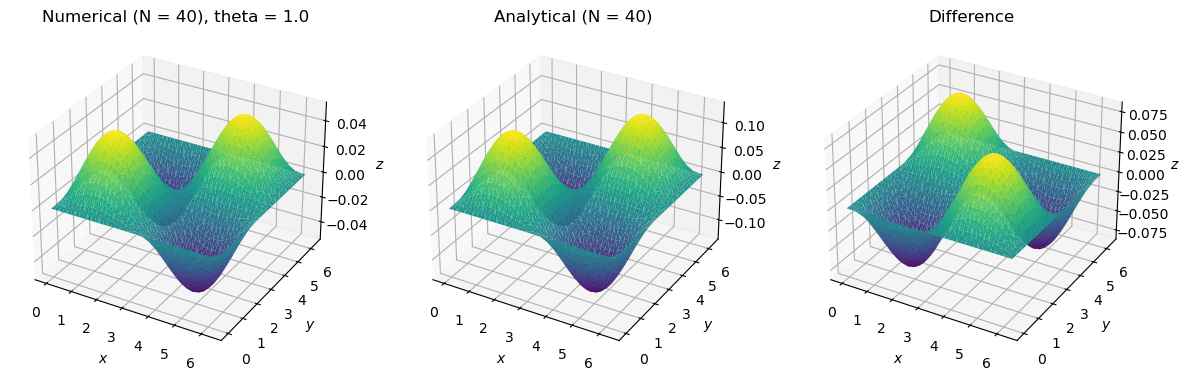

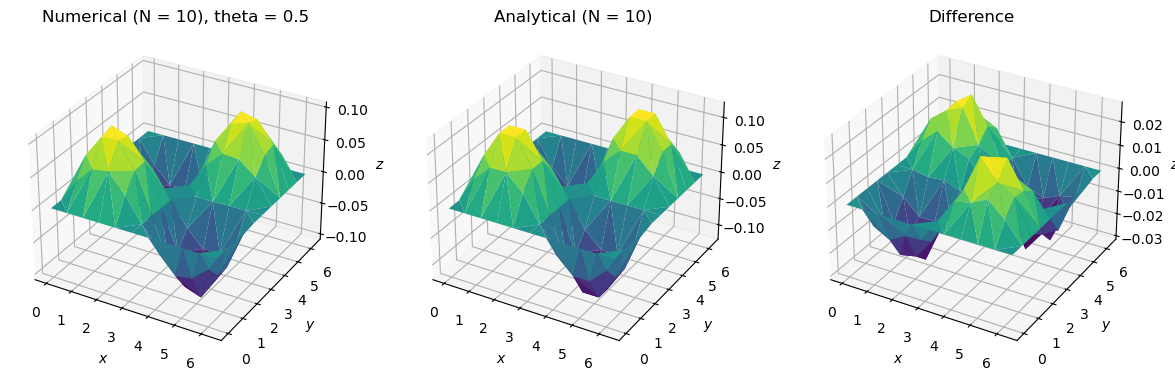

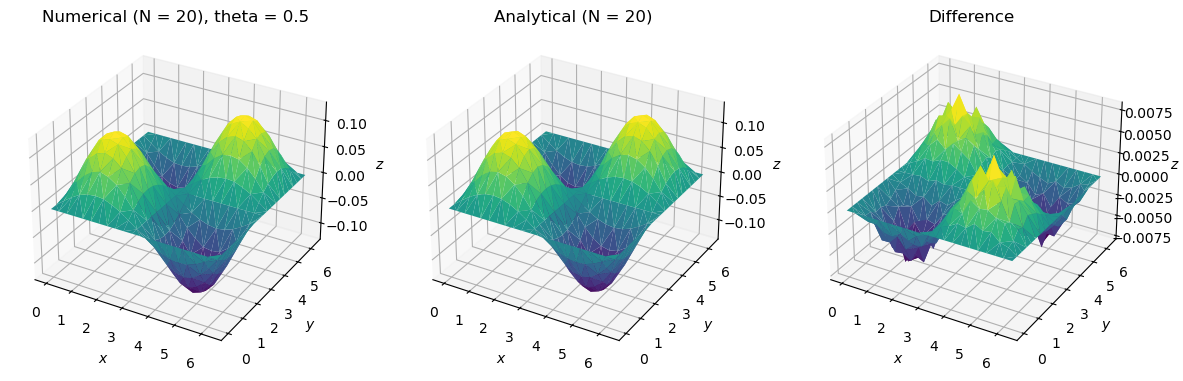

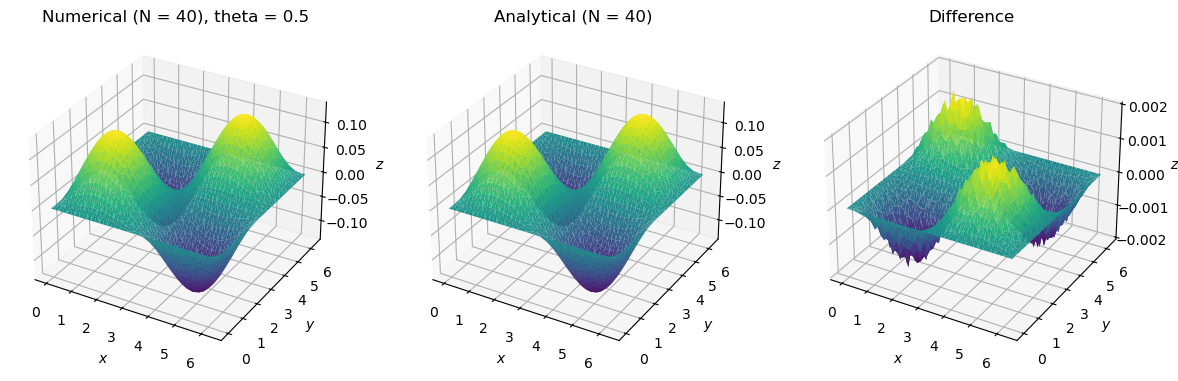

[[5.34749825e+02 1.90585913e+10 3.64252703e+29]
 [8.45806618e-02 8.37861352e-02 8.33818149e-02]
 [3.02916349e-02 8.07474967e-03 1.97393661e-03]]


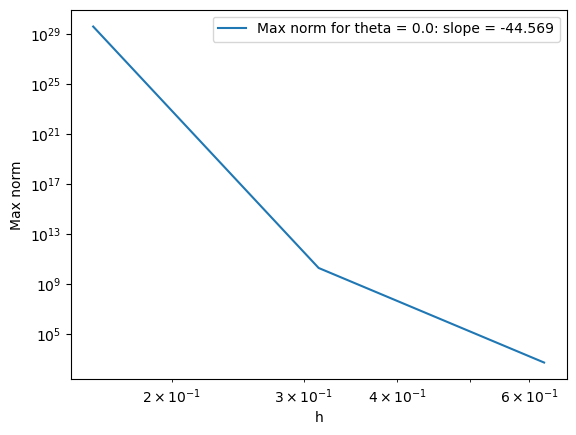

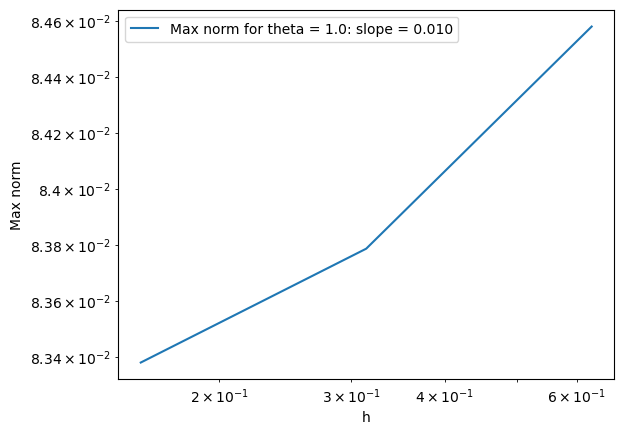

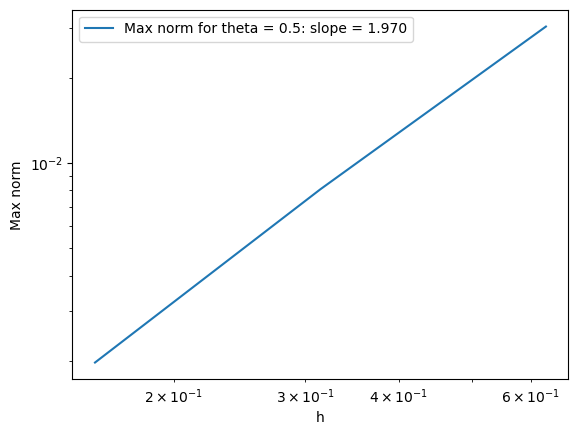

In [36]:
T = 1
alpha = 0.3
m_values = [1, 1, 2] # Trap - 2, BE,FE - 1
N_values = np.array([10, 20, 40]) # num of subdivisions
theta_values = np.array([0,1,0.5])
h = 2*np.pi/N_values # calc mesh size
a = lambda x: 1
t0 = 0

# Matrix to hold max errors for all N and theta
Errors = np.zeros((3,3))


for k,theta in enumerate(theta_values):
    theta_bar = 1- theta
    
    for j,N in enumerate(N_values):

        # Select appropriate values depending on theta
        m = m_values[k]
        dt = alpha*h[j]**m 
        N_time = int(np.ceil(T / dt)) 
        dt = T / N_time
        
        # Mesh and coordinates
        points, triangles = mt.rectangle_mesh((0,0), (2*np.pi,2*np.pi), N, N)
        X = points[:, 0]
        Y = points[:, 1]
    
        # assemble matrices
        A = assemble_stiffness_matrix(points,triangles,a)
        M = assemble_mass_matrix(points,triangles)
        
        A_tot = M + dt*theta*A
        B_tot = M - dt*thetabar*A
        
        dirichlet_nodes = extract_nodes(points,on_dirichlet_boundary)
        
        A_tot = apply_bcs_to_A(A_tot, dirichlet_nodes) 
        B_tot = apply_bcs_to_A(B_tot, dirichlet_nodes)
        
        A_tot = A_tot.tocsc()
        
        solve = factorized(A_tot)

        t = t0

        U = u_0(X, Y)
        U = U.ravel()
        # time stepping
        for i in range(N_time):
    
            # New time and index of time step
            t += dt
        
            # Compute right hand side action on U
            rhs = B_tot.dot(U)
        
            # Define \tilde F  
            load = assemble_load_vector_in_time(points, triangles, f, t)
            load_old = assemble_load_vector_in_time(points, triangles, f, t-dt)
            f_tilde = dt*(theta_bar*load_old + theta*load)
            # and assemble the load vector using f_tilde and add it to the rhs
            rhs += f_tilde
        
            # Extract coordinates associated with Dirichlet nodes as before in Lab 04
            X_dc = X[dirichlet_nodes]
            Y_dc = Y[dirichlet_nodes]
        
            # Evaluate g at boundary nodes and time t
            g_D_values = g_D(X_dc, Y_dc, t)
        
            # Apply Dirichlet boundary condition to rhs
            apply_bcs_to_b(rhs, g_D_values, dirichlet_nodes)
        
            #Solve system
            U = solve( rhs )

        U_ex = u_ex(X, Y, t)
        pt.plot_comparison_2D(X,Y,U,U_ex,triangles,f"Numerical (N = {N}), theta = {theta}",f"Analytical (N = {N})")
        # Calc max norm
        Errors[k,j] = np.max(np.abs(U - U_ex))

print(Errors)
# EOC plots
for k in range(len(Errors)):
    q_max = np.polyfit(np.log(h), np.log(Errors[k,:]), 1)[0]
    
    plt.loglog(h, Errors[k,:])
    
    plt.xlabel("h")
    plt.ylabel("Max norm")
    plt.legend([f"Max norm for theta = {theta_values[k]}: slope = {q_max:.3f}"])
    
    plt.show()
   

**d**) Now use your solver to compute a numerical solution with $u_0 = e^{-10((x-\pi)^2 + (y-\pi)^2)}$, and homogeneous Dirichlet boundary condition. Also set the forcing function $f$ to be zero. Plot the numerical solution at time $t=0, 1, 5, 10,20$ computed with $N=40$. Discuss your observations. 

[  0  42 212 424 849]
starting time loop...


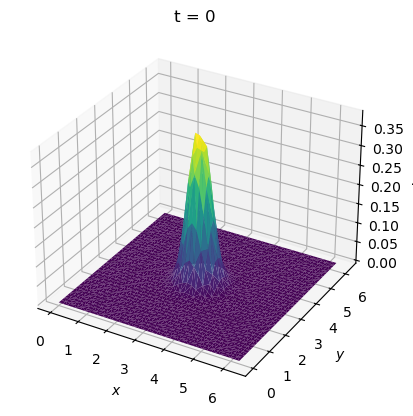

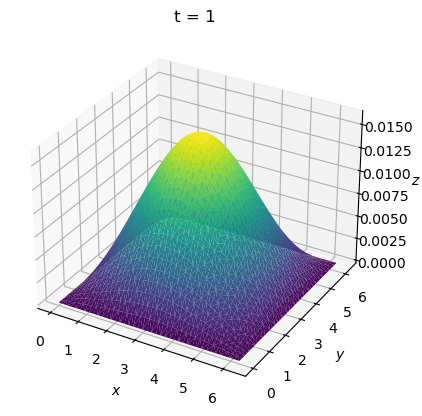

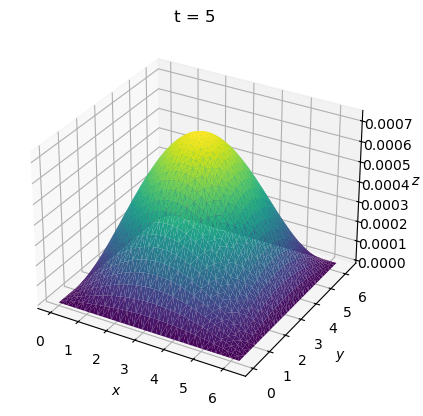

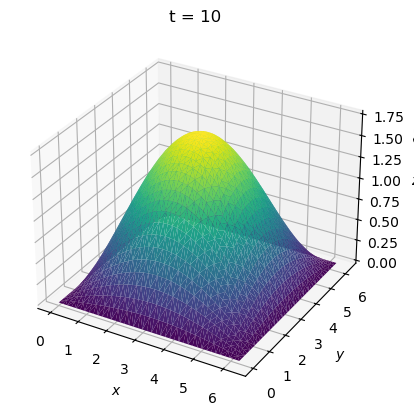

KeyboardInterrupt: 

In [37]:
def u_0_1d(x,y):
    return np.exp(-10*( (x-np.pi)**2 + (y-np.pi)**2 ) )

times = np.array([0, 1, 5, 10, 20])

N = 40
T = 20.1 # such that last index is not before t = 20
alpha = 0.15
theta = 1
theta_bar = 1 - theta
h = 2*np.pi/N # mesh size
a = lambda x: 1
t0 = 0

m = 1
dt = alpha*h**m 
N_time = int(np.ceil(T / dt))
dt = T / N_time

# Calculating which times to plot
steps_to_time = (times / dt).astype(int)
print(steps_to_time)

# Mesh and coordinates
points, triangles = mt.rectangle_mesh((0,0), (2*np.pi,2*np.pi), N, N)
X = points[:, 0]
Y = points[:, 1]

# assemble matrices
A = assemble_stiffness_matrix(points,triangles,a)
M = assemble_mass_matrix(points,triangles)

A_tot = M + dt*theta*A
B_tot = M - dt*thetabar*A

dirichlet_nodes = extract_nodes(points,on_dirichlet_boundary)

A_tot = apply_bcs_to_A(A_tot, dirichlet_nodes) 
B_tot = apply_bcs_to_A(B_tot, dirichlet_nodes)

A_tot = A_tot.tocsc()

solve = factorized(A_tot)

t = t0

U = u_0_1d(X, Y)
U = U.ravel()

# Extract coordinates associated with Dirichlet nodes as before in Lab 04
X_dc = X[dirichlet_nodes]
Y_dc = Y[dirichlet_nodes]

# time stepping
print("starting time loop...")
for i in range(N_time):

    # New time and index of time step
    t += dt

    # Compute right hand side action on U
    rhs = B_tot.dot(U)
 
    if t == dt:
        load_old = assemble_load_vector_in_time(points, triangles, f, t-dt)
    else:
        load_old = load.copy() # save computation time by not computing again
        
    load = assemble_load_vector_in_time(points, triangles, f, t)
    f_tilde = dt*(theta_bar*load_old + theta*load)
    # and assemble the load vector using f_tilde and add it to the rhs
    rhs += f_tilde

    # Evaluate g at boundary nodes and time t
    g_D_values = g_D(X_dc, Y_dc, t)

    # Apply Dirichlet boundary condition to rhs
    apply_bcs_to_b(rhs, g_D_values, dirichlet_nodes)

    #Solve system
    U = solve( rhs )
    if i in steps_to_time:
        pt.plot2D(X,Y,U,triangles,f"t = {int(t)}")



In this exercise, we implement a solver for the wave equation that is based on the finite difference method in both space and time. The equation takes the form,

\begin{alignat*}{3}
\partial_{tt} u  - \Delta u  &= f  \quad && \text{in } \Omega \times (0,T]
\\
u &= g_D \quad && \text{on } \partial \Omega \times (0, T]
\\
u(x,y,0) &=  u_0(x,y) \quad && \text{in } \Omega\\
u_t(x,0) &=  u_{t0}(x,y) \quad && \text{in } \Omega,
\end{alignat*}
where the spatial domain is the same as before, i.e. $\Omega=[0,2\pi]^2$.

Let $U_{wave}^k$ be the finite difference approxmation at time $t^k$. For the spatial discretization, we use the same finite difference matrix $A_h$ as in Lab 2. We will also use the central finite difference to approximate the   second derivative in time. The discretization can then be written as 
\begin{alignat*}{3}
\frac{U_{wave}^{k+1}-2U_{wave}^{k}+U_{wave}^{k-1}}{\Delta t^2} = ...\\
\end{alignat*}
Note: we are yet to impose the boundary condition. 


First, we recall the function that computes the finite difference matrix generated by the 5 point stencil from the 2d finite difference scheme for the Poisson problem you implemented in Lab 02.

In [18]:
def fdm_poisson2d_matrix(h, N, gm):
    """Computes sparse matrix representation for a simple finite difference scheme in space.
      
    Parameters:
    ----------
    h: float
       spatial mesh size
       here choosen the same in each spatial direction
    N: integer
       number of space subdivision in each spatial direction.
    gm: function
       grid mapping which translates double grid indices (i, j) to index of the unknown
       
    Returns:
    -------
    A: 2D sparse matrix of type dok_matrix
        Matrix for diffusion equation
    """
    
    # Allocate a (sparse)
    N_unk = (N+1)**2
    A = np.zeros((N_unk,N_unk))

    hh = h*h

    # Compute matrix A entries resulting by iterating
    # over rows and then colums of the (inner) grid indices.
    for i in range(1,N):
        for j in range(1,N):
            # Define row index related to unknown U_m(i,j)
            ri = gm(i,j)
            A[ri,ri] = 4  # U_ij
            A[ri,gm[i-1,j]] = -1  # U_{i-1,j}
            A[ri,gm[i+1,j]] = -1  # U_{i+1,j}
            A[ri,gm[i,j-1]] = -1  # U_{i,j-1}
            A[ri,gm[i,j+1]] = -1  # U_{i,j+1}

    return A

**a**) In this numerical experiment, we choose the manufacture solution
\begin{alignat*}{3}
u = \sin(x)\sin(y)\sin(\sqrt{2}t).
\end{alignat*}
Use this to compute the forcing function $f$ and the initial and boundary data. Complete the following script. Run the code with $N=10,20,40$. Present and discuss EOC in maximum norm at the final time $T=1$. 

In [19]:
def u_wave_sol(x, y, t):
    return np.sin(x)*np.sin(y)*np.sin(np.sqrt(2)*t)

In [20]:
# Mesh size
N_values = np.array([10,20,40]) 
h = (2*np.pi)/N_values
alpha = 0.2
m = 1 # trap - 1, FE,BE - 2

#  Grid
L = 2*np.pi
X,Y = np.ogrid[0:L:(N+1)*1j, 0:L:(N+1)*1j]

# What is the CFL condition for stability?
dt = alpha*h**m
M_t = np.ciel(T/dt)# nunber of time steps
dt = T / M_t # remember this!

# Total number of unknowns is N_unk = (N+1)*(N+1)
N_unk = (N+1)**2

# Sparse identity matrix ajnd convert it immediately to csc format (not csr this time!)
Id = identity(N_unk).tocsc()

A_h = fdm_poisson2d_matrix(h, N, gm)
A_h = A_h.tocsc() 


# Current time 
t = t0

# Initial condition 
Uwave_grid_1 = u_wave_sol(X,Y,0) # t = 0
Uwave_grid_0 = u_wave_sol(X,Y,0) - dt*np.sin(X)*np.sin(Y)*np.sqrt(2)*np.cos(np.sqrt(2)*0) # t_{k-1}. Hint: use the second initial condition to approximate the solution at t=-dt



# We have to flatten out the resulting (N+1)*(N+1) array using ravel()
Uwave_1 = Uwave_grid_1.ravel()
Uwave_0 = Uwave_grid_0.ravel()
# apply BC to the numerical solution at t=0 and t=-dt 
    for i in [0,N]:
        for j in range(0,N+1):
            ri = gm(i,j)       
            Uwave_0[ri] = 0       
            Uwave_1[ri] = 0      


    for j in [0,N]:
        for i in range(0,N+1):
            ri = gm(i,j)       
            Uwave_0[ri] = 0       
            Uwave_1[ri] = 0



# Start time stepping 
for i in range(M_t):
    # New time and time step
    t += tau

    # Update Uwave
    Uwave_2 = 2*Uwave_1 - Uwave_0 ...

    # apply BC to Uwave_2
    for i in [0,N]:
        for j in range(0,N+1):
            ri = gm(i,j)       
            Uwave_2[ri] = 0       
    for j in [0,N]:
        for i in range(0,N+1):
            ri = gm(i,j)       
            Uwave_2[ri] = 0       

    # Update the solutions Uwave1 and Uwave0
    ...
    ...
    
# End of time loop, calculate the maximum error





IndentationError: unexpected indent (205737972.py, line 39)

**b**) Use the same initial value $u_0$, boundary condition and forcing function as in Problem 1d), and $u_{t0}=0$. Compare with the solutions from 1d, what do you observe?
